In [1]:
import numpy as np
import pandas as pd

import lingam
from dowhy import gcm

from IPython.display import Markdown
import matplotlib.pyplot as plt
import networkx as nx
import graphviz as gv

np.random.seed(0)

## 1.サンプルデータ

In [2]:
sample_size = 1000
n_features = 6

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, sample_size))
e = pd.DataFrame(e.T, columns=[f"e{i + 1}" for i in range(n_features)])

B = np.array([
    [ 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.50, 0.00, 0.00, 0.00, 0.00, 0.00],
    [-0.20, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.00,-0.40, 0.00, 0.00, 0.00, 0.00],
    [ 0.00, 0.30, 0.20, 0.00, 0.00, 0.00],
    [ 0.00, 0.00, 0.80, 0.00, 0.00, 0.00],
])

# X = BX + e => X = (I - B)^-1 e
X = np.linalg.pinv(np.eye(n_features) - B) @ e.T

X = pd.DataFrame(X.values.T, columns=[f"x{i + 1}" for i in range(n_features)])

X.shape

### 誤差項の分散

In [3]:
e.var()

e1    1.014387
e2    1.073586
e3    0.987662
e4    0.983275
e5    0.954916
e6    1.011167
dtype: float64

### 各変数の分散

In [4]:
X.var()

x1    1.014387
x2    1.333461
x3    1.040344
x4    1.227961
x5    1.078229
x6    1.659683
dtype: float64

### 因果グラフ

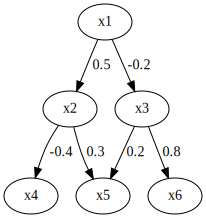

In [5]:
G = nx.from_numpy_array(B.T, create_using=nx.DiGraph)

dot = gv.Digraph()
for from_, to in G.edges:
    dot.edge(f"x{from_ + 1}", f"x{to + 1}", label=f"{B[to, from_]}")
dot

## 2. Graphical Causal Modelによる因果推論

RubinではなくDAGを用いて行うPearlの因果推論。

構造は人手で与える必要があるが、今回は正解と同じ構造だけ与えておくようにする。

In [6]:
# グラフ構造作成
G = nx.from_numpy_array(
    B.T.astype(bool).astype(int),
    create_using=nx.DiGraph,
)

map_ = {i:f"x{i + 1}" for i in range(n_features)}
G = nx.relabel_nodes(G, map_)

# 構造を与えるための独自クラスを定義
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html#using-ground-truth-models
import dowhy.gcm.ml.prediction_model

class MyCustomModel(gcm.ml.PredictionModel):
    
    def __init__(self, coefficient):
        coefs = coefficient[~np.isclose(coefficient, 0)].reshape(1, -1)

        self.coefs_ = coefs
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return (self.coefs_ @ X.T).reshape(-1, 1)

    def clone(self):
        return MyCustomModel(self.coefficient)

# GCM構築
causal_model = gcm.InvertibleStructuralCausalModel(G)

for i, coefs in enumerate(B):
    node_name = f"x{i + 1}"

    # 外生変数
    if np.isclose(coefs, 0).all():
        causal_model.set_causal_mechanism(node_name, gcm.EmpiricalDistribution())
        continue

    # 内生変数
    causal_model.set_causal_mechanism(node_name, gcm.AdditiveNoiseModel(MyCustomModel(coefs)))
        
# パラメータ推定
gcm.fit(causal_model, X)

Fitting causal mechanism of node x6: 100%|██████████| 6/6 [00:00<00:00, 550.69it/s]


### 2.1. GCMのタスク

主要なものを3つ試す。

https://www.pywhy.org/dowhy/v0.10.1/user_guide/causal_tasks/index.html

#### 平均因果効果

In [7]:
gcm.average_causal_effect(
    causal_model,
    "x5",
    {"x2": lambda _ : 1},
    {"x2": lambda _ : 0},
    observed_data=X
)

#### 介入シミュレーション

In [8]:
sim_data = gcm.interventional_samples(
    causal_model,
    {"x2": lambda _ : 5},
    #observed_data=X
    num_samples_to_draw=sample_size
)

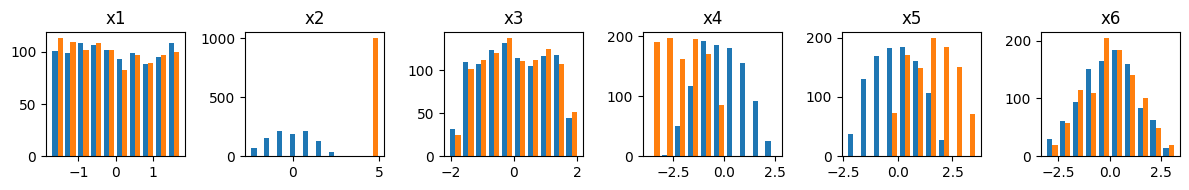

In [9]:
fig, axes = plt.subplots(1, n_features, figsize=(2 * n_features, 2))

for i, ax in enumerate(axes.flatten()):
    ax.hist((X.iloc[:, i], sim_data.iloc[:, i]))
    ax.set_title(f"x{i + 1}")

plt.tight_layout()
plt.show()

#### 反実仮想シミュレーション

In [10]:
sim_data = gcm.counterfactual_samples(
    causal_model,
    {"x2": lambda _ : 5},
    observed_data=X
)

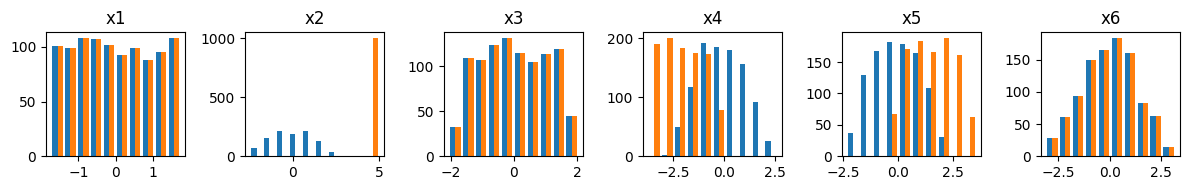

In [11]:
fig, axes = plt.subplots(1, n_features, figsize=(2 * n_features, 2))

for i, ax in enumerate(axes.flatten()):
    ax.hist((X.iloc[:, i], sim_data.iloc[:, i]))
    ax.set_title(f"x{i + 1}")

plt.tight_layout()
plt.show()